<a href="https://colab.research.google.com/github/scottspurlock/csc401-2021s/blob/main/tutorials/day10_tutorial_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 10 Tutorial: Regression
Adapted from VanderPlas
- Linear regression
- Derived features
- Under and overfitting (bias-variance trade-off)
- Metrics (MAE, MSE)


### Classification
We've been talking about supervised machine learning, where we have data with features and a target variable we want to predict. Thus far, we've focused on classification, where the target variable is limited to a set of discrete labels (e.g., mammal or not mammal).
### Regression
Another type of supervised learning is regression, when the target variable is continuous.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

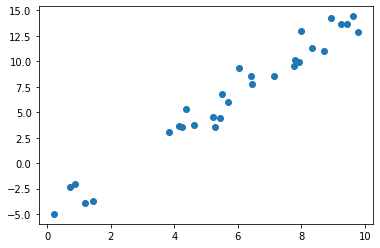

In [2]:
# Set random seed for reproducibility
np.random.seed(0)

# Number of samples to generate
n = 30

x = 10 * np.random.rand(n, 1)
y = 2 * x - 5 + np.random.randn(n, 1)

plt.scatter(x, y);

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

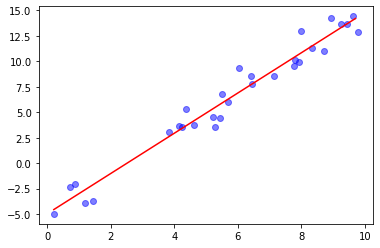

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x, y)

xfit = np.arange(x.min(), x.max(), 0.1)

# Make xfit the right shape for the predict method.
# This makes the shape (50, 1) instead of (50,)
xfit = xfit.reshape((-1, 1))
yfit = model.predict(xfit)

plt.scatter(x, y, c='blue', alpha=0.5)
plt.plot(xfit, yfit,'r');

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     [1.975283]
Model intercept: [-4.95529521]


We see that the results are very close to the inputs, as we might hope.

The LinearRegression estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
𝑦=𝑎0+𝑎1𝑥1+𝑎2𝑥2+⋯
where there are multiple 𝑥 values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data:

In [5]:
x = 10 * np.random.rand(n, 3)
y = 2 * x - 5 + np.random.randn(n, 1)

model.fit(x, y)
print('Intercept:\n', model.intercept_)
print('\nCoefficients:')
print(model.coef_)

Intercept:
 [-3.26555918 -3.26555918 -3.26555918]

Coefficients:
[[ 1.96305506 -0.12396867 -0.14180556]
 [-0.03694494  1.87603133 -0.14180556]
 [-0.03694494 -0.12396867  1.85819444]]


In this way, we can use the single ``LinearRegression`` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Derived Features
One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.

The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$

Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# For example, if we start with 3 examples of 1-dimensional data
x = np.array([
              [2], 
              [3],
              [4]
                  ])

# We can add features (columns) by squaring and cubing the original feature value.
poly = PolynomialFeatures(3, include_bias=False)
x2 = poly.fit_transform(x)
x2

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

The cleanest way to accomplish this is to use a scikit learn pipeline.
Let's make a 4th-degree polynomial model in this way:

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(4),
                           LinearRegression())


With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

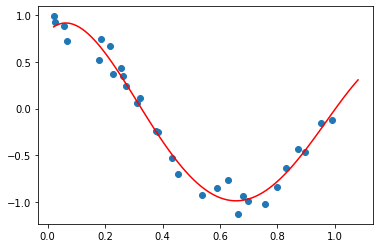

In [8]:
# Make some random data
x = np.sort(np.random.rand(n, 1))
y = np.cos(1.5 * np.pi * x) + np.random.randn(n, 1) * 0.1

# Fit a regression model
poly_model.fit(x, y)

# Make some test data
xtest = np.arange(x.min(), x.max()+0.1, 0.01)
xtest = xtest.reshape((-1, 1))
ytest = np.cos(1.5 * np.pi * xtest)

# Predict the test data
yfit = poly_model.predict(xtest)

# Show predictions on top of the random data
plt.scatter(x, y)
plt.plot(xtest, yfit, 'r');

### Under and overfitting
Notice that if we pick a lower number for our polynomial features, the model is simpler, while a higher number leads to a more complex model. If the complexity of the model isn't well-matched to the patterns in the data, we can *underfit* or *overfit* the data. Another way of saying this is that the underfit model has high bias, while the overfit model has high variance.
- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

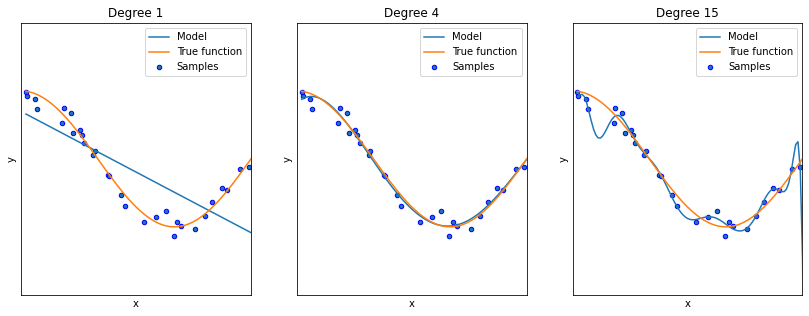

In [9]:
# Make simple to complex models
degrees = [1, 4, 15]

plt.figure(figsize=(14, 5))

# Loop over each model
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    poly_model = make_pipeline(PolynomialFeatures(degrees[i]),
                              LinearRegression())

    poly_model.fit(x, y)

    plt.plot(xtest, poly_model.predict(xtest), label="Model")
    plt.plot(xtest, ytest, label="True function")
    plt.scatter(x, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}".format(degrees[i]))

plt.show()

The diagram below is often called a validation curve, and we see the following essential features:

- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

The means of tuning the model complexity varies from model to model.

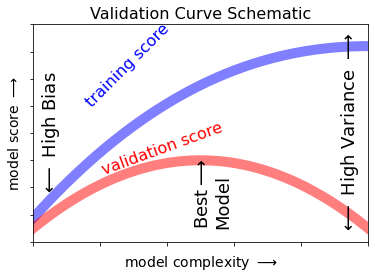

In [10]:
#@title
x1 = np.linspace(0, 1, 1000)
y1 = -(x1 - 0.5) ** 2
y2 = y1 - 0.33 + np.exp(x1 - 1)

fig, ax = plt.subplots()
ax.plot(x1, y2, lw=10, alpha=0.5, color='blue')
ax.plot(x1, y1, lw=10, alpha=0.5, color='red')

ax.text(0.15, 0.2, "training score", rotation=45, size=16, color='blue')
ax.text(0.2, -0.05, "validation score", rotation=20, size=16, color='red')

ax.text(0.02, 0.1, r'$\longleftarrow$ High Bias', size=18, rotation=90, va='center')
ax.text(0.98, 0.1, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.48, -0.12, 'Best$\\longrightarrow$\nModel', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.5)

ax.set_xlabel(r'model complexity $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Validation Curve Schematic", size=16);

### Metrics
- MAE: Mean absolute error
- MSE: Means squared error

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

poly_model = make_pipeline(PolynomialFeatures(1),
                           LinearRegression())

poly_model.fit(x, y)
ypred = poly_model.predict(xtest)

mae = mean_absolute_error(ytest, ypred)
mse = mean_squared_error(ytest, ypred)

print('MAE: {:.4f}, MSE: {:.4f}'.format(mae, mse))

MAE: 0.4489, MSE: 0.3181


In [12]:
poly_model = make_pipeline(PolynomialFeatures(4),
                           LinearRegression())

poly_model.fit(x, y)
ypred = poly_model.predict(xtest)

mae = mean_absolute_error(ytest, ypred)
mse = mean_squared_error(ytest, ypred)

print('MAE: {:.4f}, MSE: {:.4f}'.format(mae, mse))

MAE: 0.0241, MSE: 0.0009
